# Summary

Grab data from AnnData object and use it to create a graph pkl

## Background

Data can be represented in a more complete way by utilizing edge features in graph attention networks and modifying the architecture based on empirical results from 2021 

## Objective

Use self-supervised learning to learn graphical representations of data and harness edge features in improving performance of predictive tasks

## Methods

GAT, edge features, self-supervised learning, representation learning, healthcare application, single-cell transcriptomic data

- use batch labels from dataset, train GAT to get edge coefficients from preds of those labels, use this for "batch effect correction" in the model, either by penalizing reliance on these edge features, or controlling for them in the final model 
- 

In [2]:
%matplotlib inline
%load_ext memory_profiler

import os
import time
import datetime
import sys
import pickle
import scanpy as sc
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

sc.settings.verbosity=2

In [3]:
import glob
dfp = '/home/ngr4/project/scnd/data'
glob.glob(os.path.join(dfp, '*h5ad'))

['/home/ngr4/project/scnd/data/mouse_220805.h5ad',
 '/home/ngr4/project/scnd/data/mouse_210726.h5ad']

# Data

## check and modify

From Leon:
correct genotype

·   5wk WT= 7202, 72921, 72922

·   5wk SCA1= 7294, 72931, 72932

·   12wk wild-type: 22018, 2061, 2062

·   12wk SCA1: 22019, 2063, 2065

·   18wk WT: 6569, 65701, 65702

·   18wk SCA1: 6571, 65731, 65732

·   24wk wild-type: 1974, 2020, 20202

·   24wk SCA1: 1589, 2021, 20212

·   30wk WT: 5812, #5822, 58232

·   30wk SCA1: #58231, 58241, 58242


58231 and 5822 have been assigned WT and SCA1 originally, respectively

In [4]:
# load data
adata = sc.read('/home/ngr4/project/scnd/data/mouse_210726.h5ad')

#### originalm

In [5]:
# original
dt = adata.obs.loc[:, ['batch', 'genotype', 'timepoint']].drop_duplicates().sort_values(by=['timepoint', 'genotype'])
dt.groupby(['timepoint', 'genotype'])['batch'].apply(list)

timepoint  genotype
5wk        SCA1        [7294, 72931, 72932]
           WT          [7202, 72921, 72922]
12wk       SCA1         [22019, 2063, 2065]
           WT           [22018, 2061, 2062]
18wk       SCA1        [6571, 65731, 65732]
           WT          [6569, 65701, 65702]
24wk       SCA1         [1589, 2021, 20212]
           WT           [1974, 2020, 20202]
30wk       SCA1        [5822, 58241, 58242]
           WT          [5812, 58231, 58232]
Name: batch, dtype: object

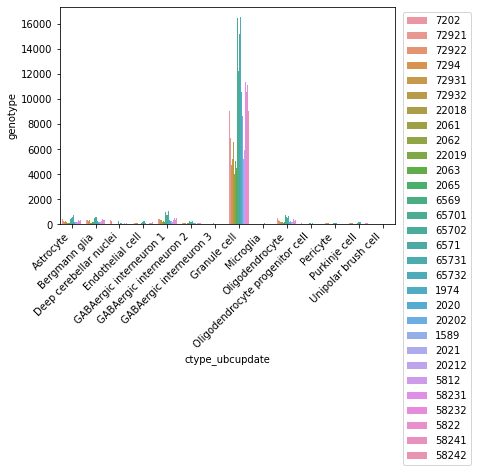

In [6]:
# count
barplot = sns.barplot(
    x='ctype_ubcupdate',
    y='genotype',
    hue='batch',
    data=adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().reset_index(),
    )
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot.legend(bbox_to_anchor=(1.01, 1))


In [7]:
dt = adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata_count.csv')

In [8]:
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata.csv')

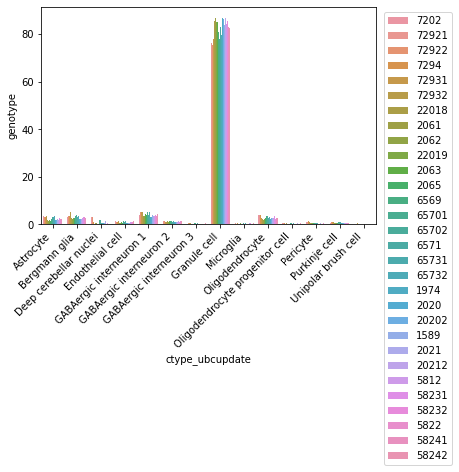

In [49]:
# percent
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype']
dt = dt.reset_index()
barplot = sns.barplot(
    x='ctype_ubcupdate',
    y='genotype',
    hue='batch',
    data=dt,
    )
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot.legend(bbox_to_anchor=(1.01, 1))

#### modified

In [82]:
# 58231 is WT, should be SCA1
# 5822 is SCA1, should be WT
adata.obs['genotype_crct'] = adata.obs['genotype'].astype(str)
adata.obs.loc[adata.obs['batch']=='58231', 'genotype_crct'] = 'SCA1'
adata.obs.loc[adata.obs['batch']=='5822', 'genotype_crct'] = 'WT'

In [83]:
# original
dt = adata.obs.loc[:, ['batch', 'genotype_crct', 'timepoint']].drop_duplicates().sort_values(by=['timepoint', 'genotype_crct'])
dt.groupby(['timepoint', 'genotype_crct'])['batch'].apply(list)

timepoint  genotype_crct
5wk        SCA1              [7294, 72931, 72932]
           WT                [7202, 72921, 72922]
12wk       SCA1               [22019, 2063, 2065]
           WT                 [22018, 2061, 2062]
18wk       SCA1              [6571, 65731, 65732]
           WT                [6569, 65701, 65702]
24wk       SCA1               [1589, 2021, 20212]
           WT                 [1974, 2020, 20202]
30wk       SCA1             [58231, 58241, 58242]
           WT                 [5812, 58232, 5822]
Name: batch, dtype: object

In [ ]:
# quick viz with umap
dt = adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata_count.csv')

In [100]:
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype_crct']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype_crct', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_220805_metadata.csv')

In [84]:
# save
adata.write('/home/ngr4/project/scnd/data/mouse_220805.h5ad')

... storing 'genotype_crct' as categorical


In [98]:
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

computing PCA
    with n_comps=50
    finished (0:02:37)


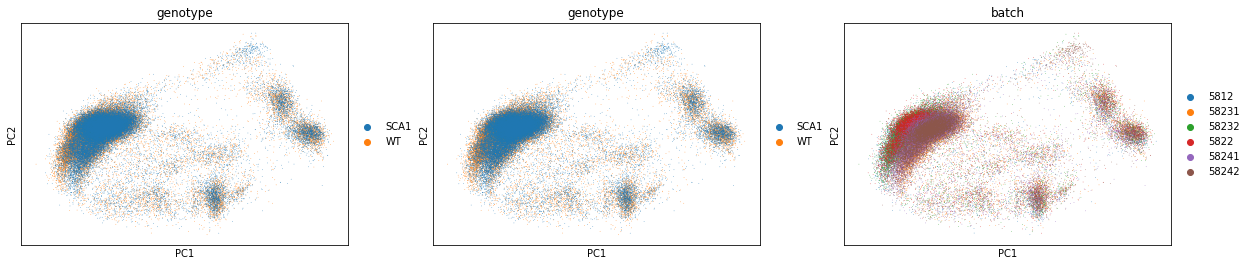

In [12]:
tdata = adata[adata.obs['timepoint']=='30wk'].copy()
sc.tl.pca(tdata)
# sc.pl.pca_scatter(tdata, color=['genotype', 'genotype_crct', 'batch'], save='_batch_gtpye_crct.png')
sc.pl.pca_scatter(tdata, color=['genotype', 'genotype', 'batch'])